<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_OB_week1_2_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **4.5** 규제가 있는 선형 모델

##### **4.5.1 릿지 회귀**

- 릿지ridge 회귀: 규제가 추가된 선형 회귀 버전
- 하이퍼파라미터 α는 모델을 얼마나 많이 규제할지 조절
- 편향 θ0는 규제되지 않음
- α를 증가시킬수록 직선에 가까워짐 => 모델의 분산이 줄어들면 편향이 커짐

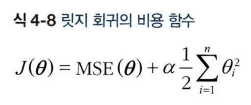

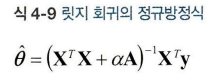

A = (n+1) x (n+1)의 단위행렬(identity matrix)

In [2]:
import numpy as np

m = 100
X = 6 * np.random.randn(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [3]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([12.53542334])

In [4]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([11.52866058])

- penalty 매개변수: "l2" 규젤 SGD가 비용 함수에 가중치 벡터의 노름의 제곱을 2로 나눈 규제항을 추가하게 만듦 (=릿지 회귀)

##### **4.5.2 라쏘 회귀**

- 라쏘Lasso 회귀: 선형 회귀의 또 다른 규제된 버전
- 비용 함수에 규제항을 더하지만, 가중치 벡터의 L1 노름을 사용

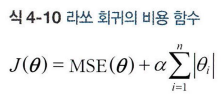

- 덜 중요한 특성의 가중치를 제거하려고 함 (=> 가중치가 0이 됨)
- 자동으로 특성 선택을 하고 *희소 모델(sparse model)*을 만듦 (=> 0이 아닌 특성의 가중치가 적음)

<라쏘와 다른 점>
1. 파라미터가 전역 최적점에 가까워질수록 그레이디언트가 작아짐 => 경사 하강법이 자동으로 느려지고 수렴에 도움이 됨
2. α를 증가시킬수록 최적의 파라미터가 원점에 더 가까워짐 (완전히 0이 되지는 않음)

- 라쏘의 비용 함수는 θi=0에서 미분 가능하지 않으나 *서브그레이디언트 벡터(subgradient vector)* **g**를 사용하면 경사 하강법 적용 가능

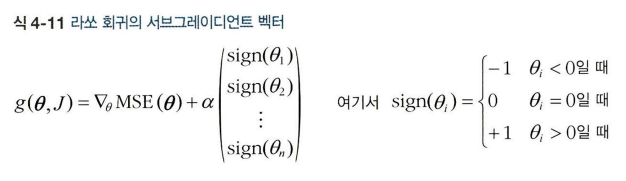

In [5]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([12.54591576])

##### **4.5.3 엘라스틱넷**

- 엘라스틱넷 elastic net: 릿지 회귀와 라쏘 회귀 절충한 모델
- 규제항 = 릿지 규제항 + 회귀 규제항, 혼합 정도 = 혼합 비율 r 사용 조절
- r = 0 => 엘라스틱넷 = 릿지 회귀
- r = 1 => 엘라스틱넷 = 라쏘 회귀
- 릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심 => 라쏘/엘라스틱넷
- 특성 수 > 훈련 샘플수 => 엘라스틱넷

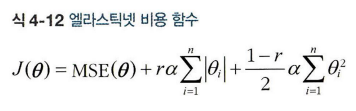

In [6]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([12.55006669])

##### **4.5.4 조기 종료**

- 조기 종료 early stopping: 검증 에러가 최솟값에 도달하면 바로 훈련 중지시키는 것
- 검증 에러가 최소에 도달하는 즉시 훈련을 멈춤

In [7]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

# 데이터 준비
poly_scaler = Pipeline([("poly_features", PolynomialFeatures(degree=90, include_bias=False)), ("std_scaler", StandardScaler())])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled,y_train.ravel()) # 훈련을 이어서 진행합니다.
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)



---



#### **4.6** 로지스틱 회귀

- **로지스틱 회귀**(logistic regression)/**로짓 회귀**(logit regression): 샘플이 특정 클래스에 속할 확률 추정
- *양성 클래스 (positive class)*: 레이블이 '1'
- *음성 클래스 (negatice class)*: 레이블이 '0'

##### **4.6.1 확률 추정**

- 입력 특성의 가중치 합 계산 - 편향을 더함 - 결괏값의 *로지스틱*logistic 출력
- *시그모이드 함수*sigmoid function: 0과 1사이의 값을 출력

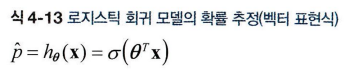

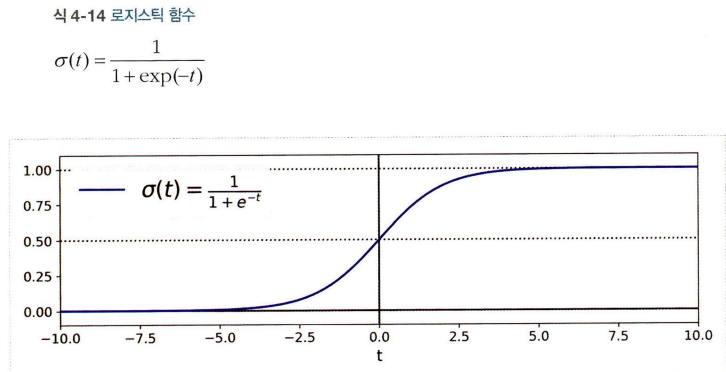

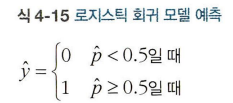

- θ^Tx > 0 => 1(양성 클래스)
- θ^Tx < 0 => 0(음성 클래스)

##### **4.6.2 훈련과 비용 함수**

- 훈련의 목적: 양성 샘플(y=1) => 높은 확률 추정, 음성 샘플(y=0) => 낮은 확률 추정하는 모델 파라미터 벡터 θ 찾기

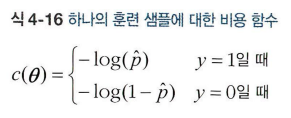

- 전체 훈련 세트에 대한 비용 함수: 모든 훈련 샘플의 비용을 평균 = 로그 손실(log loss)

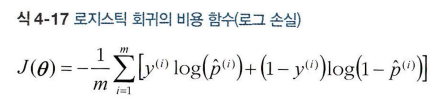

- 모든 편도함수를 포함한 그레이디언트 벡터를 만들면 배치 경사 하강법 알고리즘 사용 가능

##### **4.6.3 결정 경계**

In [8]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [9]:
X = iris["data"][:, 3:] # 꽃잎의 너비
y = (iris["target"] == 2).astype(int) # 1 Iris-Virginica면 1, 그렇지 않으면 0

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

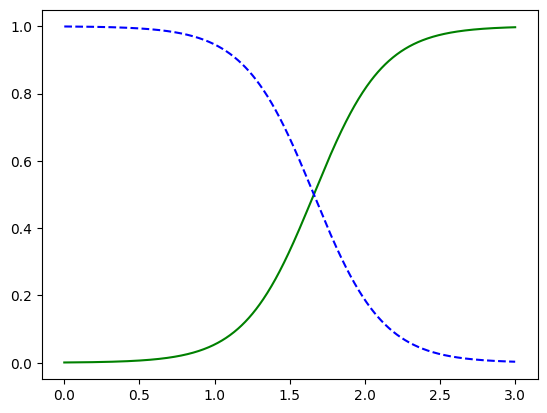

In [11]:
import matplotlib.pyplot as plt

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
# 다음은 이미지를 미려하게 출력하기 위한 맷플롯립 코드가 이어집니다.

In [12]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

- 사이킷런 LogisticRegression 모델의 규제 강도를 조절하는 하이퍼파라미터는 alpha가 아닌 그 역수에 해당하는 C => C가 높을수록 모델 규제 감소

##### **4.6.4 소프트맥스 회귀**

- **소프트맥스 회귀(softmax regression)**: 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화된 로지스틱 회귀 모델 (*다항 로지스틱 회귀(multinomial logistic regression)*)
- 샘플 x에 대해 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 s(x) 계산 - 점수에 *소프트맥스 함수(softmax function)/정규화된 지수 함수* 적용하여 클래스 확률 추정

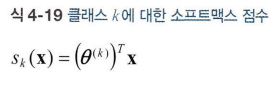

- 각 클래스는 자신만의 파라미터 벡터 θ를 가지고, *파라미터 행렬(parameter matrix)*에 행으로 저장

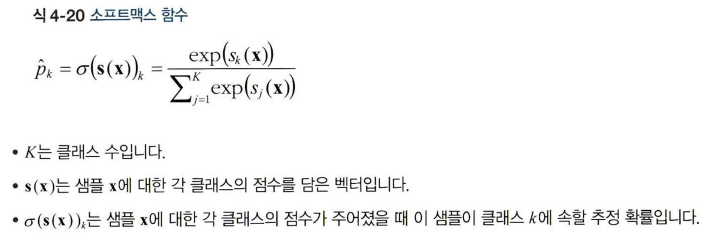

- 소프트맥스 회귀 분류기: 추정 확률이 가장 높은 클래스(가장 높은 점수) 선택

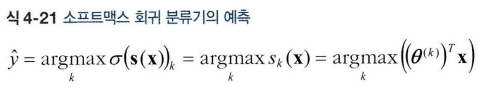

<훈련 방법>
- 목적: 모델이 타깃 클래스에 대해서 높은 확률 추정하도록 만드는 것
- *크로스 엔트로피(cross entropy)* 비용 함수를 최소화
- 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도

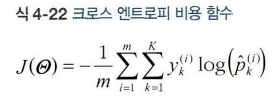

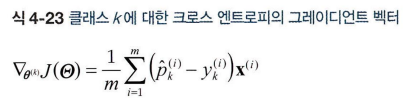

In [13]:
X = iris["data"][:, (2, 3)]   # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial')

In [14]:
softmax_reg.predict([[5, 2]])

array([2])

In [15]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626375e-07, 5.73689803e-02, 9.42630398e-01]])